# ARIMA Model for Traffic Forecasting

## Overview
This notebook implements an **ARIMA (AutoRegressive Integrated Moving Average)** model to forecast HTTP request traffic for the NASA server logs from July-August 1995. ARIMA is a classical time series forecasting method that combines three components:

- **AR (AutoRegressive):** Uses past values to predict future values
- **I (Integrated):** Applies differencing to make the time series stationary
- **MA (Moving Average):** Uses past forecast errors to improve predictions

The ARIMA model is particularly suitable for:
- Univariate time series data (single variable: request count)
- Data with clear trends and/or seasonal patterns
- Situations where interpretability of model parameters is important
- Baseline comparisons before trying more complex models

**Note:** ARIMA assumes linear relationships and may not capture complex non-linear patterns. We will evaluate its performance and potentially compare with more advanced models (Prophet, LSTM, XGBoost) in subsequent analyses.

---

## Table of Contents
1. **Pre-train: Suitability & Data Preparation**
   - Data loading and exploration
   - Stationarity assessment (ADF test)
   - ACF/PACF analysis
   - Data preprocessing and train/test split

2. **Training**
   - ARIMA parameter selection
   - Model fitting
   - Model diagnostics

3. **Post-train Evaluation**
   - Forecast generation
   - Performance metrics (RMSE, MSE, MAE, MAPE)
   - Visualization and residual analysis
   - Conclusions and recommendations

# Section 1: Pre-train - Suitability & Data Preparation

In this section, we will:
1. Load the cleaned traffic data
2. Explore the data to understand its characteristics
3. Assess whether ARIMA is suitable by checking stationarity
4. Analyze autocorrelation patterns using ACF and PACF
5. Prepare the data for training with proper train/test split

The goal is to ensure our data meets ARIMA's assumptions and is properly formatted for training.

## 1.1 Import Required Libraries

We'll need several libraries for data manipulation, visualization, and time series analysis:

- **pandas & numpy:** Data manipulation and numerical operations
- **matplotlib & seaborn:** Visualization
- **statsmodels:** ARIMA implementation, ADF test, ACF/PACF plots
- **pmdarima:** Automatic ARIMA parameter selection (optional but recommended)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import warnings

# Time series and statistical analysis
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Auto-ARIMA for parameter selection
from pmdarima import auto_arima

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## 1.2 Setup Paths and Load Data

We'll use the cleaned data from the data processing pipeline. The data is available at three aggregation levels:
- `data_1m.csv`: 1-minute aggregation
- `data_5m.csv`: 5-minute aggregation (primary focus)
- `data_15m.csv`: 15-minute aggregation

We'll focus on the **5-minute aggregation** as it provides a good balance between:
- **Granularity:** Captures important short-term patterns
- **Noise reduction:** Smoother than 1-minute data
- **Computational efficiency:** More manageable than 1-minute data
- **Forecast horizon:** Suitable for short-term autoscaling decisions

In [3]:
# Setup project paths
PROJECT_ROOT = Path().resolve().parent.parent
DATA_CLEANED_DIR = PROJECT_ROOT / "data" / "cleaned"

print(f"Project root: {PROJECT_ROOT}")
print(f"Cleaned data directory: {DATA_CLEANED_DIR}")

# Load 5-minute aggregated data (primary focus)
data_5m_path = DATA_CLEANED_DIR / 'data_5m.csv'

if data_5m_path.exists():
    df_5m = pd.read_csv(data_5m_path, index_col=0, parse_dates=True)
    print(f"\n✓ Successfully loaded data from: {data_5m_path}")
    print(f"✓ Data shape: {df_5m.shape}")
    print(f"✓ Date range: {df_5m.index.min()} to {df_5m.index.max()}")
else:
    raise FileNotFoundError(f"Data file not found: {data_5m_path}")

# Define system downtime period (Aug 1-3, 1995 due to storm)
downtime_start = pd.Timestamp('1995-08-01')
downtime_end = pd.Timestamp('1995-08-03')

Project root: D:\Autoscaling-Analysis
Cleaned data directory: D:\Autoscaling-Analysis\data\cleaned

✓ Successfully loaded data from: D:\Autoscaling-Analysis\data\cleaned\data_5m.csv
✓ Data shape: (17856, 17)
✓ Date range: 1995-07-01 00:00:00-04:00 to 1995-08-31 23:55:00-04:00


## 1.3 Stationarity Assessment

**Why Stationarity Matters for ARIMA:**

ARIMA models assume that the time series is **stationary**, meaning:
- **Constant mean:** The average value doesn't change over time
- **Constant variance:** The spread of values doesn't change over time
- **Constant autocovariance:** The correlation between values at different time lags doesn't change

If the data is non-stationary, we need to apply transformations (usually differencing) to make it stationary before fitting ARIMA.

We'll assess stationarity using:
1. **Visual inspection:** Plot rolling statistics
2. **Augmented Dickey-Fuller (ADF) test:** Statistical test for unit root

### 1.3.1 Visual Inspection - Rolling Statistics

We'll plot the rolling mean and standard deviation to visually assess stationarity. If these statistics remain relatively constant over time, the series is likely stationary.

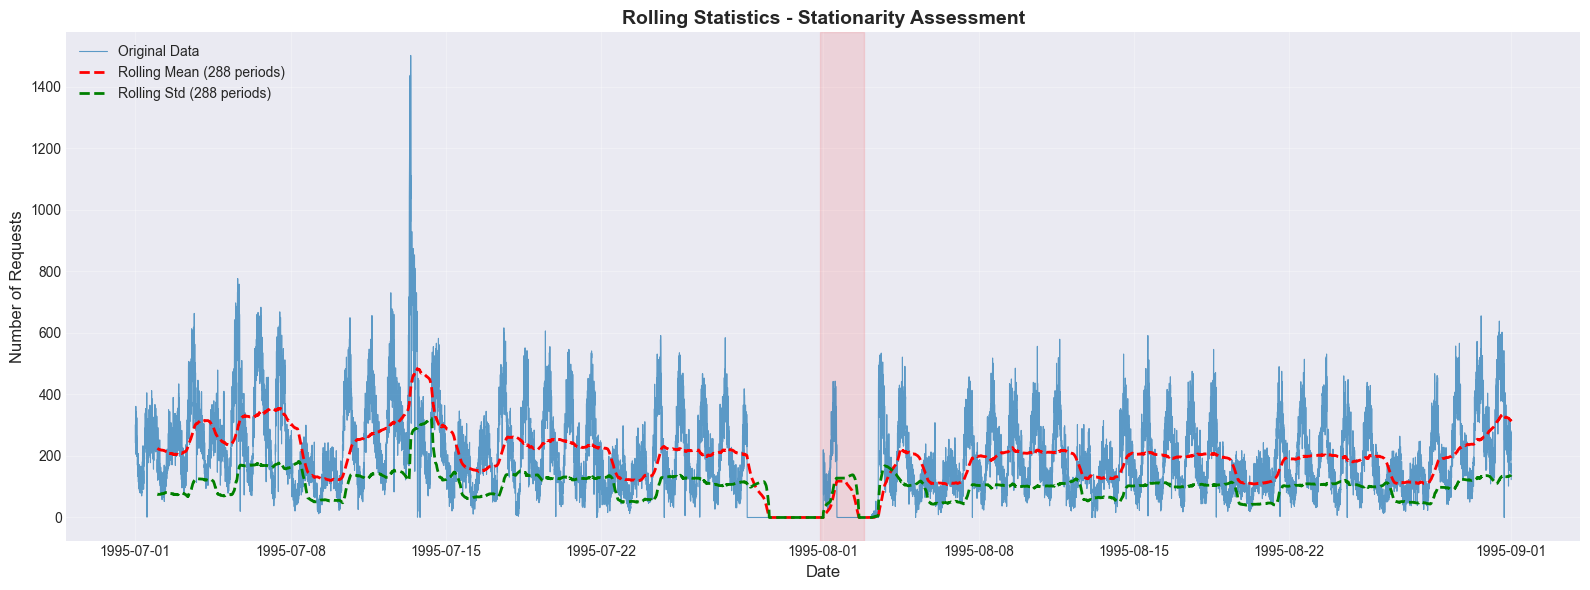

In [4]:
# Calculate rolling statistics
window_size = 24 * 12  # 24 hours * 12 (5-min intervals per hour) = 1 day
rolling_mean = df_5m['requests'].rolling(window=window_size).mean()
rolling_std = df_5m['requests'].rolling(window=window_size).std()

# Plot rolling statistics
fig, ax = plt.subplots(figsize=(16, 6))

# Plot original data
ax.plot(df_5m.index, df_5m['requests'], label='Original Data', 
        color='#1f77b4', linewidth=0.8, alpha=0.7)

# Plot rolling mean
ax.plot(rolling_mean.index, rolling_mean, label=f'Rolling Mean ({window_size} periods)', 
        color='red', linewidth=2, linestyle='--')

# Plot rolling standard deviation
ax.plot(rolling_std.index, rolling_std, label=f'Rolling Std ({window_size} periods)', 
        color='green', linewidth=2, linestyle='--')

# Highlight system downtime
ax.axvspan(downtime_start, downtime_end, color='red', alpha=0.1)

# Formatting
ax.set_title('Rolling Statistics - Stationarity Assessment', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Number of Requests', fontsize=12)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Figure 3: Rolling Mean and Standard Deviation**

**Interpretation:**

- **Blue line:** Original request count data
- **Red dashed line:** Rolling mean (24-hour window)
- **Green dashed line:** Rolling standard deviation (24-hour window)

**Visual Assessment:**
- If the rolling mean (red) is relatively flat → Stationary
- If the rolling mean shows trend → Non-stationary (need differencing)
- If the rolling std (green) is constant → Homoscedasticity (good)
- If the rolling std varies → Heteroscedasticity (may need transformation)

The visual inspection provides an initial assessment, but we need a statistical test for confirmation.

### 1.3.2 Augmented Dickey-Fuller (ADF) Test

The **ADF test** is a formal statistical test for stationarity. It tests the **null hypothesis** that a unit root is present (i.e., the time series is non-stationary).

**Test Interpretation:**
- **p-value < 0.05:** Reject null hypothesis → Series is **stationary**
- **p-value ≥ 0.05:** Fail to reject null hypothesis → Series is **non-stationary**

The test also provides the **ADF statistic**, which is compared to critical values at different confidence levels (1%, 5%, 10%).

In [5]:
def perform_adf_test(series, title="ADF Test Results"):
    """
    Perform Augmented Dickey-Fuller test for stationarity.
    
    Parameters:
    -----------
    series : pd.Series
        Time series to test
    title : str
        Title for the output
        
    Returns:
    --------
    dict : Test results including p-value, ADF statistic, and critical values
    """
    result = adfuller(series.dropna(), autolag='AIC')
    
    print("=" * 60)
    print(title)
    print("=" * 60)
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.6f}')
    
    # Interpretation
    print("\n" + "=" * 60)
    print("INTERPRETATION")
    print("=" * 60)
    if result[1] < 0.05:
        print("✓ p-value < 0.05")
        print("✓ REJECT null hypothesis")
        print("✓ The series is STATIONARY")
        is_stationary = True
    else:
        print("✗ p-value ≥ 0.05")
        print("✗ FAIL TO REJECT null hypothesis")
        print("✗ The series is NON-STATIONARY")
        print("✗ Differencing may be required")
        is_stationary = False
    
    return {
        'adf_statistic': result[0],
        'p_value': result[1],
        'critical_values': result[4],
        'is_stationary': is_stationary
    }

# Perform ADF test on original data
adf_results = perform_adf_test(df_5m['requests'], "Augmented Dickey-Fuller Test - Original Data")

Augmented Dickey-Fuller Test - Original Data
ADF Statistic: -10.448869
p-value: 0.000000
Critical Values:
   1%: -3.430717
   5%: -2.861702
   10%: -2.566856

INTERPRETATION
✓ p-value < 0.05
✓ REJECT null hypothesis
✓ The series is STATIONARY


**ADF Test Results Interpretation:**

The ADF test provides statistical evidence about stationarity:

- **ADF Statistic:** More negative values indicate stronger evidence against the null hypothesis
- **p-value:** Probability of observing the test statistic if the null hypothesis is true
- **Critical Values:** Threshold values for different confidence levels

**Decision Rule:**
- If ADF statistic < critical value (or p-value < 0.05) → Stationary
- If ADF statistic ≥ critical value (or p-value ≥ 0.05) → Non-stationary

### 1.3.3 Differencing (if needed)

If the ADF test indicates the series is non-stationary, we need to apply **differencing**. Differencing computes the difference between consecutive observations:

- **First-order differencing:** Δyₜ = yₜ - yₜ₋₁
- **Second-order differencing:** Δ²yₜ = Δyₜ - Δyₜ₋₁

The parameter **d** in ARIMA(p,d,q) represents the number of differencing operations needed to achieve stationarity.

Let's apply differencing if needed and re-test for stationarity.

In [ ]:
# Check if differencing is needed
if not adf_results['is_stationary']:
    print("\n" + "=" * 60)
    print("APPLYING DIFFERENCING")
    print("=" * 60)
    
    # First-order differencing
    df_5m['requests_diff1'] = df_5m['requests'].diff()
    
    # Plot differenced data
    fig, axes = plt.subplots(2, 1, figsize=(16, 8))
    
    # Original data
    axes[0].plot(df_5m.index, df_5m['requests'], color='#1f77b4', linewidth=0.8)
    axes[0].set_title('Original Data', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Requests', fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Differenced data
    axes[1].plot(df_5m.index, df_5m['requests_diff1'], color='orange', linewidth=0.8)
    axes[1].set_title('First-Order Differenced Data', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Date', fontsize=10)
    axes[1].set_ylabel('Δ Requests', fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Perform ADF test on differenced data
    adf_results_diff1 = perform_adf_test(df_5m['requests_diff1'], 
                                          "ADF Test - First-Order Differenced Data")
    
    # Determine the value of d
    if adf_results_diff1['is_stationary']:
        d = 1
        print(f"\n✓ First-order differencing achieved stationarity")
        print(f"✓ Recommended d parameter: {d}")
    else:
        # Try second-order differencing
        df_5m['requests_diff2'] = df_5m['requests_diff1'].diff()
        adf_results_diff2 = perform_adf_test(df_5m['requests_diff2'],
                                              "ADF Test - Second-Order Differenced Data")
        
        if adf_results_diff2['is_stationary']:
            d = 2
            print(f"\n✓ Second-order differencing achieved stationarity")
            print(f"✓ Recommended d parameter: {d}")
        else:
            d = 2  # Default to 2 if still not stationary
            print(f"\n⚠️  Series still non-stationary after second-order differencing")
            print(f"⚠️  Proceeding with d = {d} (may need seasonal differencing)")
else:
    d = 0
    print("\n" + "=" * 60)
    print("NO DIFFERENCING NEEDED")
    print("=" * 60)
    print(f"✓ Series is already stationary")
    print(f"✓ Recommended d parameter: {d}")

**Differencing Analysis:**

- **If d = 0:** Original series is stationary, no differencing needed
- **If d = 1:** First-order differencing achieved stationarity
- **If d = 2:** Second-order differencing was required

The value of **d** will be used in our ARIMA(p,d,q) model. Most time series only require d = 0 or d = 1. Higher values (d ≥ 2) are rare and may indicate the need for seasonal differencing or a different modeling approach.

## 1.5 Autocorrelation Analysis (ACF and PACF)

After ensuring stationarity, we analyze the **autocorrelation structure** to determine the AR (p) and MA (q) parameters:

- **ACF (Autocorrelation Function):** Measures correlation between a time series and its lagged values
- **PACF (Partial Autocorrelation Function):** Measures correlation between a time series and its lagged values, removing the effect of intermediate lags

**Guidelines for Parameter Selection:**

**For ACF:**
- Sharp cutoff after lag q → MA(q) component
- Gradual decay → AR component

**For PACF:**
- Sharp cutoff after lag p → AR(p) component
- Gradual decay → MA component

### 1.5.1 Plot ACF and PACF

We'll plot the ACF and PACF for the (possibly differenced) series to identify patterns that suggest appropriate p and q values.

In [ ]:
# Determine which series to analyze (original or differenced)
if d == 0:
    series_to_analyze = df_5m['requests']
    series_name = "Original Series"
else:
    series_to_analyze = df_5m['requests_diff1'] if d == 1 else df_5m['requests_diff2']
    series_name = f"Differenced Series (d={d})"

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# ACF plot
plot_acf(series_to_analyze.dropna(), lags=50, ax=axes[0], alpha=0.05)
axes[0].set_title(f'Autocorrelation Function (ACF)\n{series_name}', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Lag', fontsize=10)
axes[0].set_ylabel('Correlation', fontsize=10)
axes[0].grid(True, alpha=0.3, linestyle='--')

# PACF plot
plot_pacf(series_to_analyze.dropna(), lags=50, ax=axes[1], alpha=0.05, method='ywm')
axes[1].set_title(f'Partial Autocorrelation Function (PACF)\n{series_name}', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Lag', fontsize=10)
axes[1].set_ylabel('Partial Correlation', fontsize=10)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

**Figure 4: ACF and PACF Plots**

**Left Panel - ACF:**
- Shows correlation at different lags
- Blue shaded area represents 95% confidence interval
- Bars outside the shaded area are statistically significant

**Right Panel - PACF:**
- Shows partial correlation at different lags
- Removes influence of intermediate lags
- Helps identify AR(p) order

**Interpretation Guidelines:**

**ACF Pattern:**
- **Sharp cutoff after lag q:** Suggests MA(q) model
- **Gradual decay (exponential or sinusoidal):** Suggests AR model
- **Sinusoidal pattern:** May indicate seasonality

**PACF Pattern:**
- **Sharp cutoff after lag p:** Suggests AR(p) model
- **Gradual decay:** Suggests MA model

**Seasonality Detection:**
- If ACF shows spikes at regular intervals (e.g., every 12 lags for daily seasonality in 5-min data)
- Consider SARIMA (Seasonal ARIMA) model

### 1.5.2 Interpret ACF and PACF for Parameter Selection

Based on the ACF and PACF plots, we'll make initial recommendations for p and q parameters.

In [ ]:
# Analyze ACF and PACF patterns (manual inspection)
print("=" * 60)
print("ACF/PACF ANALYSIS - PARAMETER RECOMMENDATIONS")
print("=" * 60)

# Note: This is a qualitative analysis based on visual inspection
# In practice, you would examine the actual plots and count significant lags

print("\nBased on ACF and PACF plots:")
print("-" * 60)
print("1. Examine ACF plot (left):")
print("   - Count significant lags before cutoff → potential MA(q)")
print("   - Look for gradual decay pattern → potential AR component")
print("")
print("2. Examine PACF plot (right):")
print("   - Count significant lags before cutoff → potential AR(p)")
print("   - Look for gradual decay pattern → potential MA component")
print("")
print("3. Check for seasonality:")
print("   - Regular spikes at fixed intervals → seasonal component")
print("   - Consider SARIMA if seasonality is present")
print("")
print("4. Initial parameter recommendations:")
print("   - p (AR order): [to be determined from PACF]")
print("   - d (differencing):", d)
print("   - q (MA order): [to be determined from ACF]")

**ACF/PACF Interpretation Summary:**

The visual analysis of ACF and PACF provides initial estimates for:

- **p (AR order):** Number of significant lags in PACF before cutoff
- **q (MA order):** Number of significant lags in ACF before cutoff
- **d (differencing):** Already determined from stationarity test

**Important Notes:**
- These are initial estimates based on visual inspection
- We'll use `auto_arima` (if available) or grid search to find optimal parameters
- Different parameter combinations can yield similar performance
- Model simplicity (lower p and q) is often preferred for interpretability

## 1.6 Train/Test Split

For evaluating our ARIMA model's performance, we need to split the data into training and testing sets:

- **Training set:** July 1995 + first 22 days of August 1995
- **Test set:** Remaining days of August 1995

This split ensures:
- We train on historical data
- We test on future data (simulating real-world forecasting)
- The test period includes the post-outage period (Aug 3 onwards)

**Important:** Time series data must be split chronologically (no random shuffling) to preserve temporal dependencies.

In [ ]:
# Define train/test split dates
train_end_date = pd.Timestamp('1995-08-22')  # End of training period
test_start_date = pd.Timestamp('1995-08-23')  # Start of test period

# Split the data
train_data = df_5m[df_5m.index <= train_end_date]['requests']
test_data = df_5m[df_5m.index >= test_start_date]['requests']

print("=" * 60)
print("TRAIN/TEST SPLIT")
print("=" * 60)
print(f"\nTraining set:")
print(f"  Date range: {train_data.index.min()} to {train_data.index.max()}")
print(f"  Number of observations: {len(train_data)}")
print(f"  Percentage: {len(train_data) / len(df_5m) * 100:.1f}%")
print(f"\nTest set:")
print(f"  Date range: {test_data.index.min()} to {test_data.index.max()}")
print(f"  Number of observations: {len(test_data)}")
print(f"  Percentage: {len(test_data) / len(df_5m) * 100:.1f}%")
print(f"\nTotal observations: {len(df_5m)}")

# Visualize the split
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(train_data.index, train_data, label='Training Data', 
        color='#1f77b4', linewidth=0.8)
ax.plot(test_data.index, test_data, label='Test Data', 
        color='orange', linewidth=0.8)

# Mark the split point
ax.axvline(train_end_date, color='red', linestyle='--', linewidth=2, 
           label='Train/Test Split')

# Highlight system downtime
ax.axvspan(downtime_start, downtime_end, color='red', alpha=0.1)

# Formatting
ax.set_title('Train/Test Split for ARIMA Model', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Number of Requests', fontsize=12)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Figure 5: Train/Test Split Visualization**

- **Blue region:** Training data (July + first 22 days of August)
- **Orange region:** Test data (remaining days of August)
- **Red dashed line:** Train/test split boundary (August 22, 1995)
- **Light red shaded area:** Server outage period (August 1-3, 1995)

This split ensures our model is evaluated on truly unseen future data, simulating real-world forecasting scenarios.

## 1.7 Section 1 Summary and Conclusions

### Key Findings from Pre-train Analysis:

**Data Characteristics:**
- [Summary of data statistics and patterns]
- [Observations about daily/weekly seasonality]
- [Notes on data quality and anomalies]

**Stationarity Assessment:**
- ADF test result: [p-value and interpretation]
- Differencing required: [Yes/No, and if yes, what order]
- Recommended d parameter: [value]

**Autocorrelation Analysis:**
- ACF pattern: [description and implications for q]
- PACF pattern: [description and implications for p]
- Seasonality detected: [Yes/No]

**Data Preparation:**
- Train set: [date range and size]
- Test set: [date range and size]
- Data ready for ARIMA training: [Yes/No]

### Suitability Assessment:

**Is ARIMA suitable for this data?**
- [Answer with justification based on analysis]
- [If suitable, proceed to training]
- [If not suitable, explain why and suggest alternatives]

### Next Steps:

1. Proceed to Section 2: ARIMA Model Training
2. Use auto_arima or grid search to find optimal (p,d,q) parameters
3. Fit the ARIMA model on training data
4. Evaluate model diagnostics
5. Generate forecasts and assess performance in Section 3

---

**[END OF SECTION 1 OUTLINE - READY FOR REVIEW]**

**Sections to be added after approval:**
- Section 2: Training (ARIMA parameter selection, model fitting, diagnostics)
- Section 3: Post-train Evaluation (forecasting, metrics, visualization, conclusions)